# Capstone Phase 2 - Modeling  
The previous notebook (capstone-phase1) was getting a bit long to run comfortably, so let's start a new one for ML.


### Import some libraries we'll need

In [1]:
import joblib
import pandas as pd
import numpy as np
from sklearn import preprocessing
from zipfile import ZipFile

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix

### Some Utility stuff

In [22]:
def plt_norm_confmat(model, X, y, title, fname=None, labels=None):
    fig, ax = plt.subplots(figsize=(7, 7))
    display = plot_confusion_matrix(model, X, y, display_labels=labels, cmap=plt.cm.Blues, 
                                    normalize='true', xticks_rotation='vertical', ax=ax)
    display.ax_.set_title(title)
    if fname is not None:
        file = './images/' + fname + '.png'
        plt.savefig(file, dpi=300, bbox_inches='tight')

In [4]:
def transform_data(df):
    no_labels = df.drop(['label', 'attack_cat'], axis=1)
    one_hot = pd.get_dummies(no_labels, columns=['proto', 'service', 'state'], prefix=['proto', 'service', 'state'])
    scaler = preprocessing.StandardScaler().fit(one_hot)
    standardized = scaler.transform(one_hot)
    std = pd.DataFrame(standardized, columns=one_hot.columns)

    labels = df['label'].copy()
    cats = df['attack_cat'].copy()
    
    return std, labels, cats

### Load data and apply Transformations identified during exploration phase.

In [5]:
with ZipFile('./Data/UNSW_NB15 training and testing sets.zip') as datasets_zip:
    # open each file and read in to a DataFrame
    with datasets_zip.open('UNSW_NB15_training-set.csv') as training_file:
        training_data = pd.read_csv(training_file, index_col='id')
    with datasets_zip.open('UNSW_NB15_testing-set.csv') as testing_file:
        testing_data = pd.read_csv(testing_file, index_col='id')

In [6]:
training_data_std, training_labels, training_cats = transform_data(training_data)
testing_data_std, testing_labels, testing_cats = transform_data(testing_data)

In [7]:
# let's check it
training_data_std.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_ssl,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
0,-0.191029,-0.104456,-0.135769,-0.049134,-0.102726,-0.576371,0.703839,1.578100,-0.389897,-0.273700,...,-0.017874,-0.284764,-0.008273,1.119382,-0.940239,-0.002388,-0.10717,-0.021762,-0.002388,-0.002388
1,-0.109485,-0.046014,0.172599,-0.046410,0.188544,-0.576345,-1.141901,1.560002,-0.389928,-0.069233,...,-0.017874,-0.284764,-0.008273,1.119382,-0.940239,-0.002388,-0.10717,-0.021762,-0.002388,-0.002388
2,0.040699,-0.089845,-0.026933,-0.048527,-0.012133,-0.576734,-1.141901,1.560002,-0.389964,-0.252044,...,-0.017874,-0.284764,-0.008273,1.119382,-0.940239,-0.002388,-0.10717,-0.021762,-0.002388,-0.002388
3,0.049729,-0.060624,-0.063212,-0.047016,-0.098563,-0.576737,-1.141901,1.560002,-0.389958,-0.275821,...,-0.017874,-0.284764,-0.008273,1.119382,-0.940239,-0.002388,-0.10717,-0.021762,-0.002388,-0.002388
4,-0.140417,-0.075235,-0.117630,-0.047554,-0.102057,-0.576617,0.723268,1.560002,-0.389927,-0.275561,...,-0.017874,-0.284764,-0.008273,1.119382,-0.940239,-0.002388,-0.10717,-0.021762,-0.002388,-0.002388


Let's transform the labels using `preprocessing.LabelEncoder`, it can easily transform between encoding and original labels.  
~~Let's also try a simple integer mapping for the classes, it might work better for some methods.~~

In [24]:
#y_train = training_cats.map({'Normal':0, 'Generic':1, 'Exploits':2, 'Fuzzers':3, 'DoS':4, 
#                           'Reconnaissance':5, 'Analysis':6, 'Backdoor':7, 'Shellcode':8, 'Worms':9}).astype(int)
#y_test = testing_cats.map({'Normal':0, 'Generic':1, 'Exploits':2, 'Fuzzers':3, 'DoS':4, 
#                           'Reconnaissance':5, 'Analysis':6, 'Backdoor':7, 'Shellcode':8, 'Worms':9}).astype(int)

label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(training_cats)
y_test = label_encoder.fit_transform(testing_cats)

In [9]:
training_cats.unique()

array(['Normal', 'Backdoor', 'Analysis', 'Fuzzers', 'Shellcode',
       'Reconnaissance', 'Exploits', 'DoS', 'Worms', 'Generic'],
      dtype=object)

In [32]:
label_encoder.classes_

array(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'], dtype=object)

In [34]:
class_names = list(label_encoder.classes_)
#class_names = ['Normal', 'Generic', 'Exploits', 'Fuzzers', 'DoS', 'Reconnaissance', 'Analysis', 'Backdoor', 'Shellcode', 'Worms']

In [35]:
print(class_names)

['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Normal', 'Reconnaissance', 'Shellcode', 'Worms']


We can also transform the labels in to a binary vector with `preprocessing.LabelBinarizer` if that is preferred by some methods.

In [5]:
# Use LabelBinarizer to convert target classes to binary vectors
binarizer = preprocessing.LabelBinarizer()
y_train_bin = binarizer.fit_transform(training_cats)
y_test_bin = binarizer.fit_transform(testing_cats)
#print(binarizer.classes_)

### Load feature subsets

In [84]:
feature_subsets = joblib.load('./data/feature_subsets.pkl')

In [85]:
feature_subsets.keys()

dict_keys(['ig', 'anova', 'vt', 'mad', 'corr', 'rfe'])

In [38]:
#checking something...
for key, vals in feature_subsets.items():
    if 'is_sm_ips_ports' in vals:
        print(f'{key} features contains is_sm_ips_ports')

corr features contains is_sm_ips_ports
rfe features contains is_sm_ips_ports


In [15]:
#subsets = pd.read_pickle("./data/subsets.pkl")
#subsets.head()

,Info Gain,ANOVA F-val,Var Thresh,MAD,Corr
0,sbytes,ct_dst_sport_ltm,spkts,sload,dur
1,smean,ct_dst_src_ltm,dpkts,rate,spkts
2,sload,ct_srv_dst,sbytes,dload,dpkts
3,dbytes,ct_src_dport_ltm,dbytes,sbytes,rate
4,rate,ct_srv_src,rate,dbytes,sttl


In [16]:
# checking something...
#train_std_corr = training_data_std[subsets['Corr']].copy()
#test_std_corr = testing_data_std[subsets['Corr']].copy()

Make a new DataFrame for each feature subset.

In [39]:
train_std_ig = training_data_std[feature_subsets['ig']].copy()
test_std_ig = testing_data_std[feature_subsets['ig']].copy()

train_std_anova = training_data_std[feature_subsets['anova']].copy()
test_std_anova = testing_data_std[feature_subsets['anova']].copy()

train_std_vt = training_data_std[feature_subsets['vt']].copy()
test_std_vt = testing_data_std[feature_subsets['vt']].copy()

train_std_mad = training_data_std[feature_subsets['mad']].copy()
test_std_mad = testing_data_std[feature_subsets['mad']].copy()

train_std_corr = training_data_std[feature_subsets['corr']].copy()
test_std_corr = testing_data_std[feature_subsets['corr']].copy()

train_std_rfe = training_data_std[feature_subsets['rfe']].copy()
test_std_rfe = testing_data_std[feature_subsets['rfe']].copy()

In [40]:
train_std_ig.head()

,sbytes,smean,sload,dbytes,rate,dmean,dur,ct_dst_sport_ltm,ct_srv_dst,ct_state_ttl,dttl,ct_srv_src,dload,ct_dst_src_ltm,dinpkt,sttl,ct_src_dport_ltm,dpkts,ct_dst_ltm,sinpkt
0,-0.049134,-0.458048,-0.389897,-0.102726,-0.576371,-0.314240,-0.191029,-0.554373,-0.753074,-1.366486,1.578100,-0.775991,-0.273700,-0.705529,-0.080885,0.703839,-0.544736,-0.135769,-0.645013,-0.132788
1,-0.046410,-0.414076,-0.389928,0.188544,-0.576345,3.800869,-0.109485,-0.554373,-0.288257,-0.318711,1.560002,3.147666,-0.069233,-0.614256,-0.073735,-1.141901,-0.544736,0.172599,-0.645013,-0.129251
2,-0.048527,-0.443391,-0.389964,-0.012133,-0.576734,2.709185,0.040699,-0.554373,-0.288257,-0.318711,1.560002,-0.215468,-0.252044,-0.522983,0.014711,-1.141901,-0.544736,-0.026933,-0.520827,-0.104126
3,-0.047016,-0.414076,-0.389958,-0.098563,-0.576737,-0.232945,0.049729,-0.554373,-0.753074,-0.318711,1.560002,-0.775991,-0.275821,-0.522983,0.002046,-1.141901,-0.544736,-0.063212,-0.520827,-0.115034
4,-0.047554,-0.409190,-0.389927,-0.102057,-0.576617,-0.306498,-0.140417,-0.554373,2.779535,-0.318711,1.560002,3.147666,-0.275561,2.854115,-0.012721,0.723268,-0.420468,-0.117630,-0.520827,-0.129549


# Modeling

## Let's try a Naive Bayes classifier  
https://scikit-learn.org/stable/modules/naive_bayes.html

Neither ComplementNB, nor MultinomialNB likes negative values.  Should I have used some other type of normalization instead of the Standard Scaler? Something that would generate only non-negative values? MinMaxScaler [0,1] "is often used as an alternative to zero mean, unit variance scaling"  
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler

In [25]:
#from sklearn.naive_bayes import ComplementNB
#from sklearn.naive_bayes import MultinomialNB

In [26]:
#mnb_params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}
#mnb_gs = GridSearchCV(MultinomialNB(), mnb_params, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

In [27]:
#mnb_gs_results = mnb_gs.fit(train_std_ig, y_train)

In [28]:
#train_std_ig.head()

In [29]:
#print(mnb_gs_results.best_score_)
#print(mnb_gs_results.best_estimator_)
#print(mnb_gs_results.best_params_)

#### Try Gaussian NB....

In [41]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [42]:
gnb = GaussianNB()
gnb.fit(train_std_ig, y_train)
cv_scores = cross_val_score(gnb, train_std_ig, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print('Cross validation scores: ', cv_scores)
print('Mean score: ', cv_scores.mean())
print('Standard Dev: ', cv_scores.std())

Cross validation scores:  [0.54914597 0.5327364  0.54639557 0.46823315 0.39842592]
Mean score:  0.498987400787217
Standard Dev:  0.0582423354572515


In [43]:
joblib.dump(gnb, './data/gnb_model_ig.pkl')
#gnb = joblib.load('./data/gnb_model_ig.pkl')

['./data/gnb_model_ig.pkl']

In [44]:
#y_pred_gnb = gnb.predict(test_std_ig)
y_pred_gnb = cross_val_predict(gnb, train_std_ig, y_train, cv=5)  # save the test set for final models
y_pred_gnb

array([7, 6, 3, ..., 1, 5, 5])

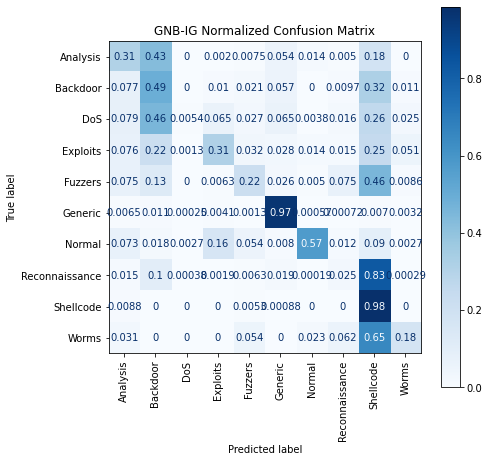

              precision    recall  f1-score   support

           0       0.05      0.35      0.09      2000
           1       0.04      0.40      0.08      1746
           2       0.22      0.01      0.01     12264
           3       0.49      0.31      0.38     33393
           4       0.46      0.22      0.30     18184
           5       0.92      0.97      0.94     40000
           6       0.98      0.56      0.72     56000
           7       0.08      0.03      0.04     10491
           8       0.03      0.98      0.06      1133
           9       0.01      0.17      0.02       130

    accuracy                           0.50    175341
   macro avg       0.33      0.40      0.26    175341
weighted avg       0.69      0.50      0.55    175341

0.4989876868501948


In [48]:
# make sure to use y_train, not y_test since we're using cross_val_predict, not predicting on the test set
con_mat_gnb = confusion_matrix(y_train, y_pred_gnb)
#print(con_mat_gnb)
plt_norm_confmat(gnb, train_std_ig, y_train, 'GNB-IG Normalized Confusion Matrix', 
                 fname='gnb_ig_conf_mat', labels=class_names)
plt.show()
class_rep_gnb = classification_report(y_train, y_pred_gnb, zero_division=0)
rep_dict_gnb_ig = classification_report(y_train, y_pred_gnb, zero_division=0, output_dict=True)
print(class_rep_gnb)
acc_gnb = accuracy_score(y_train, y_pred_gnb)
print(acc_gnb)

Try GaussianNB on the other feature sets

In [56]:
# ANOVA selected features
gnb_anova = GaussianNB()
gnb_anova.fit(train_std_anova, y_train)
cv_scores_anova = cross_val_score(gnb_anova, train_std_anova, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print('Cross validation scores: ', cv_scores_anova)
print('Mean score: ', cv_scores_anova.mean())
print('Standard Dev: ', cv_scores_anova.std())

Cross validation scores:  [0.57814594 0.56866659 0.56812479 0.50761378 0.33928368]
Mean score:  0.5123669547967329
Standard Dev:  0.09009536430085348


In [57]:
joblib.dump(gnb_anova, './data/gnb_model_anova.pkl')
#gnb_anova = joblib.load('./data/gnb_model_anova.pkl')

['./data/gnb_model_anova.pkl']

In [58]:
#y_pred_gnb_anova = gnb_anova.predict(test_std_anova)
y_pred_gnb_anova = cross_val_predict(gnb_anova, train_std_anova, y_train, cv=5)  # save the test set for final models
y_pred_gnb_anova

array([7, 6, 3, ..., 5, 5, 5])

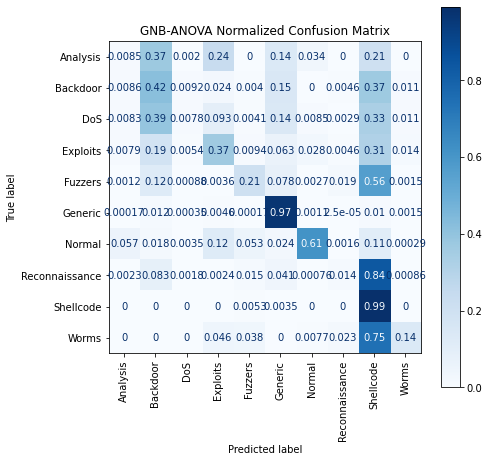

              precision    recall  f1-score   support

           0       0.00      0.01      0.00      2000
           1       0.04      0.40      0.08      1746
           2       0.19      0.01      0.02     12264
           3       0.55      0.37      0.44     33393
           4       0.51      0.21      0.29     18184
           5       0.83      0.97      0.89     40000
           6       0.97      0.59      0.73     56000
           7       0.17      0.01      0.02     10491
           8       0.03      0.99      0.05      1133
           9       0.02      0.14      0.03       130

    accuracy                           0.51    175341
   macro avg       0.33      0.37      0.26    175341
weighted avg       0.68      0.51      0.56    175341

0.5123673299456488


In [59]:
# make sure to use y_train, not y_test since we're using cross_val_predict, not predicting on the test set
con_mat_gnb_anova = confusion_matrix(y_train, y_pred_gnb_anova)
#print(con_mat_gnb_anova)
plt_norm_confmat(gnb_anova, train_std_anova, y_train, 'GNB-ANOVA Normalized Confusion Matrix', 
                 fname='gnb_anova_conf_mat', labels=class_names)
plt.show()
class_rep_gnb_anova = classification_report(y_train, y_pred_gnb_anova, zero_division=0)
rep_dict_gnb_anova = classification_report(y_train, y_pred_gnb_anova, zero_division=0, output_dict=True)
print(class_rep_gnb_anova)
acc_gnb_anova = accuracy_score(y_train, y_pred_gnb_anova)
print(acc_gnb_anova)

In [60]:
# Variance Threshold selected features
gnb_vt = GaussianNB()
gnb_vt.fit(train_std_vt, y_train)
cv_scores_vt = cross_val_score(gnb_vt, train_std_vt, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print('Cross validation scores: ', cv_scores_vt)
print('Mean score: ', cv_scores_vt.mean())
print('Standard Dev: ', cv_scores_vt.std())

Cross validation scores:  [0.3518207  0.34897913 0.34915022 0.25039922 0.15381544]
Mean score:  0.29083294273584837
Standard Dev:  0.0786257849871457


In [61]:
joblib.dump(gnb_vt, './data/gnb_model_vt.pkl')
#gnb_vt = joblib.load('./data/gnb_model_vt.pkl')

['./data/gnb_model_vt.pkl']

In [62]:
#y_pred_gnb_vt = gnb_vt.predict(test_std_vt)
y_pred_gnb_vt = cross_val_predict(gnb_vt, train_std_vt, y_train, cv=5)  # save the test set for final models
y_pred_gnb_vt

array([7, 6, 3, ..., 8, 8, 8])

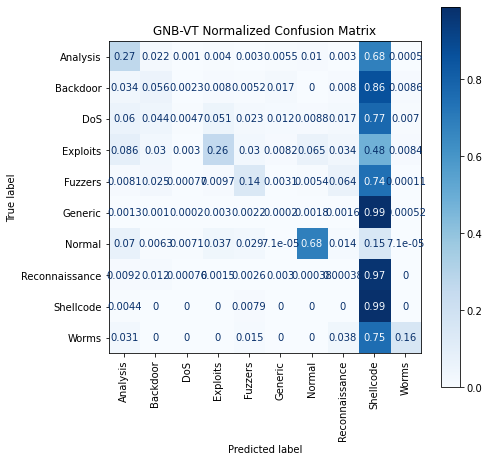

              precision    recall  f1-score   support

           0       0.06      0.26      0.10      2000
           1       0.04      0.06      0.04      1746
           2       0.10      0.00      0.01     12264
           3       0.72      0.26      0.38     33393
           4       0.45      0.14      0.22     18184
           5       0.02      0.00      0.00     40000
           6       0.94      0.68      0.79     56000
           7       0.00      0.00      0.00     10491
           8       0.01      0.99      0.02      1133
           9       0.04      0.16      0.07       130

    accuracy                           0.29    175341
   macro avg       0.24      0.25      0.16    175341
weighted avg       0.50      0.29      0.35    175341

0.29083329055953827


In [63]:
# make sure to use y_train, not y_test since we're using cross_val_predict, not predicting on the test set
con_mat_gnb_vt = confusion_matrix(y_train, y_pred_gnb_vt)
#print(con_mat_gnb_vt)
plt_norm_confmat(gnb_vt, train_std_vt, y_train, 'GNB-VT Normalized Confusion Matrix', 
                 fname='gnb_vt_conf_mat', labels=class_names)
plt.show()
class_rep_gnb_vt = classification_report(y_train, y_pred_gnb_vt, zero_division=0)
rep_dict_gnb_vt = classification_report(y_train, y_pred_gnb_vt, zero_division=0, output_dict=True)
print(class_rep_gnb_vt)
acc_gnb_vt = accuracy_score(y_train, y_pred_gnb_vt)
print(acc_gnb_vt)

In [64]:
# Median Absolute Deviation selected features
gnb_mad = GaussianNB()
gnb_mad.fit(train_std_mad, y_train)
cv_scores_mad = cross_val_score(gnb_mad, train_std_mad, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print('Cross validation scores: ', cv_scores_mad)
print('Mean score: ', cv_scores_mad.mean())
print('Standard Dev: ', cv_scores_mad.std())

Cross validation scores:  [0.55156976 0.54035018 0.55754534 0.48984829 0.38405384]
Mean score:  0.5046734825495467
Standard Dev:  0.06486355791466777


In [65]:
joblib.dump(gnb_mad, './data/gnb_model_mad.pkl')
#gnb_mad = joblib.load('./data/gnb_model_mad.pkl')

['./data/gnb_model_mad.pkl']

In [66]:
#y_pred_gnb_mad = gnb_mad.predict(test_std_mad)
y_pred_gnb_mad = cross_val_predict(gnb_mad, train_std_mad, y_train, cv=5)  # save the test set for final models
y_pred_gnb_mad

array([7, 6, 3, ..., 5, 5, 5])

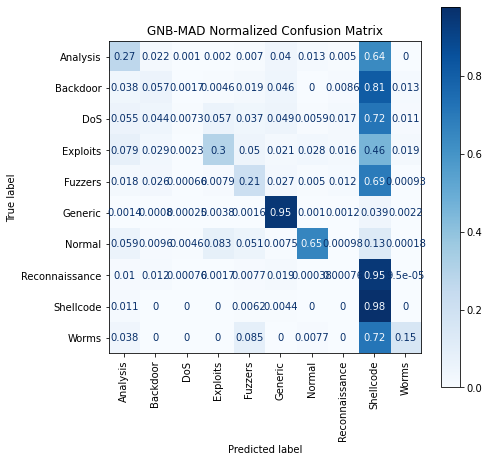

              precision    recall  f1-score   support

           0       0.06      0.25      0.10      2000
           1       0.04      0.06      0.04      1746
           2       0.20      0.01      0.01     12264
           3       0.58      0.30      0.39     33393
           4       0.43      0.21      0.28     18184
           5       0.93      0.95      0.94     40000
           6       0.97      0.63      0.76     56000
           7       0.01      0.00      0.00     10491
           8       0.02      0.98      0.04      1133
           9       0.02      0.15      0.03       130

    accuracy                           0.50    175341
   macro avg       0.32      0.35      0.26    175341
weighted avg       0.69      0.50      0.56    175341

0.504673750007129


In [96]:
# make sure to use y_train, not y_test since we're using cross_val_predict, not predicting on the test set
con_mat_gnb_mad = confusion_matrix(y_train, y_pred_gnb_mad)
#print(con_mat_gnb_mad)
plt_norm_confmat(gnb_mad, train_std_mad, y_train, 'GNB-MAD Normalized Confusion Matrix', 
                 fname='gnb_mad_conf_mat', labels=class_names)
plt.show()
class_rep_gnb_mad = classification_report(y_train, y_pred_gnb_mad, zero_division=0)
rep_dict_gnb_mad = classification_report(y_train, y_pred_gnb_mad, zero_division=0, output_dict=True)
print(class_rep_gnb_mad)
acc_gnb_mad = accuracy_score(y_train, y_pred_gnb_mad)
print(acc_gnb_mad)

In [68]:
#y_train.transform(training_cats)

In [69]:
train_std_corr.columns

Index(['dur', 'spkts', 'dpkts', 'rate', 'sttl', 'sload', 'dload', 'dinpkt',
       'sjit', 'djit', 'swin', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_state_ttl', 'ct_dst_sport_ltm', 'is_ftp_login',
       'ct_flw_http_mthd', 'is_sm_ips_ports'],
      dtype='object')

In [70]:
# Correlation selected features
gnb_corr = GaussianNB()
gnb_corr.fit(train_std_corr, y_train)
cv_scores_corr = cross_val_score(gnb_corr, train_std_corr, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print('Cross validation scores: ', cv_scores_corr)
print('Mean score: ', cv_scores_corr.mean())
print('Standard Dev: ', cv_scores_corr.std())

Cross validation scores:  [0.4073113  0.41867229 0.43198928 0.3759838  0.37766625]
Mean score:  0.40232458474221183
Standard Dev:  0.02224400723604726


In [71]:
joblib.dump(gnb_corr, './data/gnb_model_corr.pkl')
#gnb_corr = joblib.load('./data/gnb_model_corr.pkl')

['./data/gnb_model_corr.pkl']

In [72]:
#y_pred_gnb_corr = gnb_corr.predict(test_std_corr)
y_pred_gnb_corr = cross_val_predict(gnb_corr, train_std_corr, y_train, cv=5)  # save the test set for final models
y_pred_gnb_corr

array([7, 3, 3, ..., 5, 5, 5])

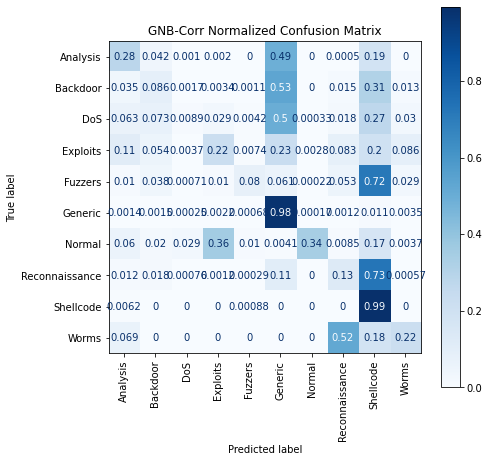

              precision    recall  f1-score   support

           0       0.06      0.28      0.10      2000
           1       0.03      0.09      0.05      1746
           2       0.06      0.01      0.02     12264
           3       0.27      0.23      0.25     33393
           4       0.61      0.08      0.14     18184
           5       0.68      0.98      0.80     40000
           6       0.99      0.34      0.51     56000
           7       0.23      0.13      0.17     10491
           8       0.03      0.99      0.05      1133
           9       0.01      0.22      0.01       130

    accuracy                           0.40    175341
   macro avg       0.30      0.33      0.21    175341
weighted avg       0.61      0.40      0.42    175341

0.40232461318231333


In [74]:
# make sure to use y_train, not y_test since we're using cross_val_predict, not predicting on the test set
con_mat_gnb_corr = confusion_matrix(y_train, y_pred_gnb_corr)
#print(con_mat_gnb_corr)
plt_norm_confmat(gnb_corr, train_std_corr, y_train, 'GNB-Corr Normalized Confusion Matrix', 
                 fname='gnb_corr_conf_mat', labels=class_names)
plt.show()
class_rep_gnb_corr = classification_report(y_train, y_pred_gnb_corr, zero_division=0)
rep_dict_gnb_corr = classification_report(y_train, y_pred_gnb_corr, zero_division=0, output_dict=True)
print(class_rep_gnb_corr)
acc_gnb_corr = accuracy_score(y_train, y_pred_gnb_corr)
print(acc_gnb_corr)

### Discovery - at least for the naive bayes classifier the `is_sm_ips_ports` feature seems to make the performance much worse, when the feature is included all instances were classified as `Normal`....

In [87]:
#opt_list = joblib.load('./data/rfecv_selected_features.pkl')

In [45]:
#train_std_rfe = training_data_std[opt_list].copy()
#test_std_rfe = testing_data_std[opt_list].copy()

In [89]:
gnb_rfe = GaussianNB()
gnb_rfe.fit(train_std_rfe, y_train)
cv_scores_rfe = cross_val_score(gnb_rfe, train_std_rfe, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print('Cross validation scores: ', cv_scores_rfe)
print('Mean score: ', cv_scores_rfe.mean())
print('Standard Dev: ', cv_scores_rfe.std())

Cross validation scores:  [0.28147367 0.24241474 0.24352686 0.20779628 0.17751226]
Mean score:  0.2305447617562096
Standard Dev:  0.0353075741077206


In [90]:
joblib.dump(gnb_rfe, './data/gnb_model_rfe.pkl')
#gnb_rfe = joblib.load('./data/gnb_model_rfe.pkl')

['./data/gnb_model_rfe.pkl']

In [91]:
#y_pred_gnb_rfe = gnb_rfe.predict(test_std_rfe)
y_pred_gnb_rfe = cross_val_predict(gnb_rfe, train_std_rfe, y_train, cv=5)  # save the test set for final models
y_pred_gnb_rfe

array([9, 6, 6, ..., 6, 6, 6])

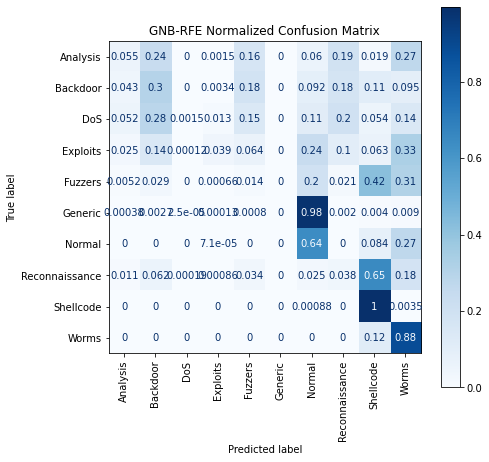

              precision    recall  f1-score   support

           0       0.05      0.04      0.05      2000
           1       0.05      0.28      0.08      1746
           2       0.48      0.00      0.00     12264
           3       0.87      0.04      0.07     33393
           4       0.05      0.01      0.01     18184
           5       0.01      0.00      0.01     40000
           6       0.41      0.66      0.51     56000
           7       0.06      0.01      0.01     10491
           8       0.05      1.00      0.09      1133
           9       0.00      0.85      0.01       130

    accuracy                           0.23    175341
   macro avg       0.20      0.29      0.08    175341
weighted avg       0.34      0.23      0.18    175341

0.23054505221254584


In [93]:
# make sure to use y_train, not y_test since we're using cross_val_predict, not predicting on the test set
con_mat_gnb_rfe = confusion_matrix(y_train, y_pred_gnb_rfe)
#print(con_mat_gnb_rfe)
plt_norm_confmat(gnb_rfe, train_std_rfe, y_train, 'GNB-RFE Normalized Confusion Matrix', 
                 fname='gnb_rfe_conf_mat', labels=class_names)
plt.show()
class_rep_gnb_rfe = classification_report(y_train, y_pred_gnb_rfe, zero_division=0)
rep_dict_gnb_rfe = classification_report(y_train, y_pred_gnb_rfe, zero_division=0, output_dict=True)
print(class_rep_gnb_rfe)
acc_gnb_rfe = accuracy_score(y_train, y_pred_gnb_rfe)
print(acc_gnb_rfe)

These are pretty terrible results, but NB isn't a very powerful algorithm.

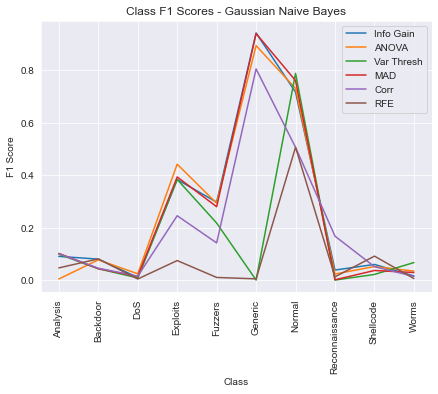

In [189]:
reports = [rep_dict_gnb_ig, rep_dict_gnb_anova, rep_dict_gnb_vt, rep_dict_gnb_mad, rep_dict_gnb_corr, rep_dict_gnb_rfe]
lgnds = ['Info Gain', 'ANOVA', 'Var Thresh', 'MAD', 'Corr', 'RFE']
labels = ['0', '1', '2', '3','4', '5', '6', '7', '8', '9']
fig, ax = plt.subplots(figsize=(7, 5))
sns.set_style('darkgrid')

for report, lgnd in zip(reports, lgnds):
    f1_scores = []
    for lab in labels:
        f1_scores.append(report[lab]['f1-score'])
    sns.lineplot(x=label_encoder.classes_, y=f1_scores, label=lgnd)
plt.xlabel('Class')
plt.xticks(rotation=90, horizontalalignment='center')
plt.ylabel('F1 Score')
plt.title('Class F1 Scores - Gaussian Naive Bayes')
plt.legend()
plt.savefig('./images/class_f1s_nb.png', dpi=300, bbox_inches='tight')
plt.show()

In [180]:
# let's grab come metrics so we can plot them togther
f1_acc = [('Accuracy', 'Info Gain', rep_dict_gnb_ig['accuracy']),
          ('Accuracy', 'ANOVA', rep_dict_gnb_anova['accuracy']),
          ('Accuracy', 'Var Thresh', rep_dict_gnb_vt['accuracy']),
          ('Accuracy', 'MAD', rep_dict_gnb_mad['accuracy']),
          ('Accuracy', 'Corr', rep_dict_gnb_corr['accuracy']),
          ('Accuracy', 'RFE', rep_dict_gnb_rfe['accuracy']),
          ('Weighted Avg F1', 'Info Gain', rep_dict_gnb_ig['weighted avg']['f1-score']),
          ('Weighted Avg F1', 'ANOVA', rep_dict_gnb_anova['weighted avg']['f1-score']),
          ('Weighted Avg F1', 'Var Thresh', rep_dict_gnb_vt['weighted avg']['f1-score']),
          ('Weighted Avg F1', 'MAD', rep_dict_gnb_mad['weighted avg']['f1-score']),
          ('Weighted Avg F1', 'Corr', rep_dict_gnb_corr['weighted avg']['f1-score']),
          ('Weighted Avg F1', 'RFE', rep_dict_gnb_rfe['weighted avg']['f1-score'])]
metric_df = pd.DataFrame(f1_acc, columns=['Metric', 'Feature Subset', 'Score'])

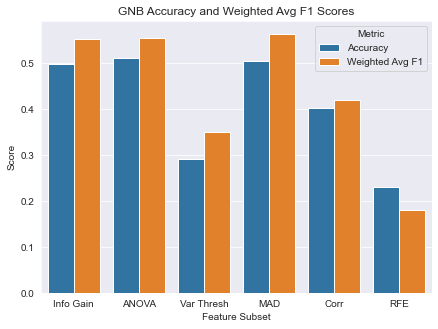

In [185]:
plt.figure(figsize=(7, 5))
sns.set_style('darkgrid')
metric_chart = sns.barplot(x='Feature Subset', y='Score', hue='Metric', data=metric_df)
metric_chart.set_title('GNB Accuracy and Weighted Avg F1 Scores')
plt.savefig('./images/feat_subset_acc_f1.png', dpi=300, bbox_inches='tight')
plt.show()

In [119]:
#'is_sm_ips_ports' in feature_subsets['rfe']

I wonder what will happen if I drop that feature...

## K-nearest neighbors

In [15]:
from sklearn.neighbors import KNeighborsClassifier

In [81]:
# start with default settings; k=5, distance=minkowski
knn_model = KNeighborsClassifier(n_jobs=-1)
knn_model.fit(train_std_ig, y_train)

KNeighborsClassifier()

In [ ]:
joblib.dump(knn_model, './data/knn_model_ig_5.pkl')
#knn_model = joblib.load('./data/knn_model_ig_5.pkl')

In [82]:
# predict classes for the test set
y_pred = knn_model.predict(test_std_ig)

Let's see how we did

In [85]:
con_mat = confusion_matrix(y_test, y_pred)
print(con_mat)

class_rep = classification_report(y_test, y_pred)
print(class_rep)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.6862094932711461


68.62% with 5 neighbors, not great results

In [ ]:
knn_model2 = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)
knn_model2.fit(train_std_ig, y_train)

In [ ]:
joblib.dump(knn_model2, './data/knn_model_ig_7.pkl')
#knn_model2 = joblib.load('./data/knn_model_ig_7.pkl')

In [88]:
y_pred2 = knn_model2.predict(test_std_ig)

In [90]:
con_mat = confusion_matrix(y_test, y_pred2)
#print(con_mat)
plt_norm_confmat(knn_model2, test_std_ig, y_test, '7 NN Normalized Confusion Matrix', 
                 fname='knn_ig_7_conf_mat', labels=class_names)
plt.show()

class_rep = classification_report(y_test, y_pred2)
print(class_rep)
acc2 = accuracy_score(y_test, y_pred2)
print(acc2)

[[27017   395   830  7659    52   165   857     9    16     0]
 [  628 16189   413  1580    42    11     1     0     3     4]
 [  379   217  8389   678   768   326   242   119    13     1]
 [ 1683   197   722  3007   240    42    87    80     4     0]
 [  175   131  2378   242   830    74   167    86     6     0]
 [  136    16   748   781   103  1688    16     7     1     0]
 [   42    81   297    27   118     2    70    40     0     0]
 [   32    81   254    41    94     7    36    38     0     0]
 [   42    13   101    94     6    86     0     0    36     0]
 [    2     1    25     7     2     0     0     0     0     7]]
              precision    recall  f1-score   support

           0       0.90      0.73      0.80     37000
           1       0.93      0.86      0.89     18871
           2       0.59      0.75      0.66     11132
           3       0.21      0.50      0.30      6062
           4       0.37      0.20      0.26      4089
           5       0.70      0.48      0.57 

69.56% with 7 neighbors, very slighly better...maybe fewer will work better? or maybe we need significantly more?

In [ ]:
knn_model3 = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
knn_model3.fit(train_std_ig, y_train)

In [ ]:
joblib.dump(knn_model3, './data/knn_model_ig_3.pkl')
#knn_model3 = joblib.load('./data/knn_model_ig_3.pkl')

In [91]:
y_pred3 = knn_model3.predict(test_std_ig)

In [92]:
con_mat = confusion_matrix(y_test, y_pred3)
print(con_mat)
class_rep = classification_report(y_test, y_pred3)
print(class_rep)
acc3 = accuracy_score(y_test, y_pred3)
print(acc3)

[[27078   370   964  7476    61   134   882    23    11     1]
 [  737 15970   323  1760    56    12     2     7     2     2]
 [  533   296  7303   931   743   573   305   425    20     3]
 [ 1812   204   579  3002   159    45   156    98     6     1]
 [  210   160  1690   406   792   162   200   457    12     0]
 [  259    19   544   879   269  1445    14    55     2    10]
 [   49    87   203    79    79     9   111    60     0     0]
 [   54    87   185    91    63     6    71    25     1     0]
 [   59    13    80    82    22    89     0     0    31     2]
 [    3     1    19     5     6     3     0     0     0     7]]
              precision    recall  f1-score   support

           0       0.88      0.73      0.80     37000
           1       0.93      0.85      0.89     18871
           2       0.61      0.66      0.63     11132
           3       0.20      0.50      0.29      6062
           4       0.35      0.19      0.25      4089
           5       0.58      0.41      0.48 

67.73% with 3 neighbors, this model probably just isn't well suited to this data set  
Let's try one more, there are 10 classes to predict, let's try 11 neighbors

In [ ]:
knn_model4 = KNeighborsClassifier(n_neighbors=11, n_jobs=-1)
knn_model4.fit(train_std_ig, y_train)

In [ ]:
joblib.dump(knn_model4, './data/knn_model_ig_11.pkl')
#knn_model4 = joblib.load('./data/knn_model_ig_11.pkl')

In [93]:
y_pred4 = knn_model4.predict(test_std_ig)

In [94]:
con_mat = confusion_matrix(y_test, y_pred4)
print(con_mat)
class_rep = classification_report(y_test, y_pred4)
print(class_rep)
acc4 = accuracy_score(y_test, y_pred4)
print(acc4)

[[26929   371   842  7785    55   165   829     6    18     0]
 [  630 16136   442  1593    48    10     3     2     3     4]
 [  355   173  8420   724   872   280   186   107    14     1]
 [ 1596   178   721  3110   273    21   102    58     3     0]
 [  155   118  2326   251   985    58   102    89     5     0]
 [  127    10   710   775   135  1723     7     9     0     0]
 [   56    75   294    20   130     1    72    29     0     0]
 [   36    75   272    30    92     4    48    26     0     0]
 [   34    10    96    94    14    89     0     0    41     0]
 [    3     1    22     8     0     4     0     0     0     6]]
              precision    recall  f1-score   support

           0       0.90      0.73      0.80     37000
           1       0.94      0.86      0.90     18871
           2       0.60      0.76      0.67     11132
           3       0.22      0.51      0.30      6062
           4       0.38      0.24      0.29      4089
           5       0.73      0.49      0.59 

69.77%, again not much improvement
We either need different features, or more likely a more powerful model

Checking the results shows where the misclassificatons are happening most often:  
- Normal, ok  
- Generic, ok  
- Exploits, ok, highest misclass=DoS  
- Fuzzers, highest misclass=Normal  
- DoS, not ok, highest misclass=Exploits  
- Reconnaissance, not great, highest misclass=Exploits  
- Analysis, poor, highest misclass=Exploits, DoS  
- Backdoor, poor, highest miclass=Exploits  
- Shellcode, poor, highest misclass=Exploits, Fuzzers  
- Worms, poor, highest misclass=Exploits  

This is probably due to the relatively small number of some attack categories.  Those classes are often misclassified as *Exploits*.

### Let's try it with GridSeachCV

In [18]:
from sklearn.model_selection import GridSearchCV

https://medium.com/@erikgreenj/k-neighbors-classifier-with-gridsearchcv-basics-3c445ddeb657  
https://www.ritchieng.com/machine-learning-efficiently-search-tuning-param/

In [28]:
# since I've already run several tests using minkowski distance I'll leave those out, even though they weren't CV'd
params = {'n_neighbors':[5, 11, 19], 'weights':['uniform', 'distance'], 'metric':['euclidean', 'manhattan']}
knn_gs = GridSearchCV(KNeighborsClassifier(), params, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

In [29]:
knn_gs_results = knn_gs.fit(train_std_ig, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [31]:
print(knn_gs_results.best_score_)
print(knn_gs_results.best_estimator_)
print(knn_gs_results.best_params_)

0.7513416713717841
KNeighborsClassifier(metric='manhattan', n_neighbors=11)
{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}


75% accuracy looks decent, considering this isn't a very powerful model.

Let's see all of the results

In [37]:
results = knn_gs_results.cv_results_
results_df = pd.DataFrame(results)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.093810,0.000000,553.094102,8.798253,euclidean,5,uniform,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei...",0.797098,0.806748,0.625764,0.743203,0.083136,12
1,0.098164,0.003078,548.080443,2.152474,euclidean,5,distance,"{'metric': 'euclidean', 'n_neighbors': 5, 'wei...",0.799100,0.810307,0.621520,0.743642,0.086474,11
2,0.163780,0.009183,543.430753,3.931821,euclidean,11,uniform,"{'metric': 'euclidean', 'n_neighbors': 11, 'we...",0.800811,0.808596,0.633976,0.747794,0.080544,7
3,0.132989,0.014661,545.358709,7.847026,euclidean,11,distance,"{'metric': 'euclidean', 'n_neighbors': 11, 'we...",0.803292,0.812326,0.626516,0.747378,0.085542,8
4,0.131787,0.007439,568.469995,14.267871,euclidean,19,uniform,"{'metric': 'euclidean', 'n_neighbors': 19, 'we...",0.798775,0.808271,0.629664,0.745570,0.082049,10
5,0.136094,0.012091,563.023459,14.878991,euclidean,19,distance,"{'metric': 'euclidean', 'n_neighbors': 19, 'we...",0.801666,0.811693,0.624822,0.746061,0.085826,9
6,0.130454,0.011011,731.575947,2.443129,manhattan,5,uniform,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.801495,0.807963,0.635636,0.748365,0.079755,5
7,0.116475,0.010368,724.358208,1.174405,manhattan,5,distance,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.803360,0.809879,0.630332,0.747857,0.083146,6
8,0.100615,0.000966,722.717544,3.753106,manhattan,11,uniform,"{'metric': 'manhattan', 'n_neighbors': 11, 'we...",0.804164,0.811658,0.638202,0.751342,0.080060,1
9,0.108833,0.009576,723.466347,4.693253,manhattan,11,distance,"{'metric': 'manhattan', 'n_neighbors': 11, 'we...",0.806851,0.814413,0.631033,0.750766,0.084720,3


Let's save this for later.

In [45]:
joblib.dump(knn_gs, './data/knn_grid_search.pkl')
#knn_gs = joblib.load('./data/knn_grid_search.pkl')
joblib.dump(knn_gs_results, './data/knn_gs_results.pkl')
#knn_gs_results = joblib.load('./data/knn_gs_results.pkl')

['./data/knn_gs_results.pkl']

In [ ]:
knn_model_best = KNeighborsClassifier(n_neighbors=11, weights='uniform', metric='manhattan', n_jobs=-1)
knn_model_best.fit(train_std_ig, y_train)

In [60]:
joblib.dump(knn_model_best, './data/knn_model_best_ig.pkl')
#knn_model_best = joblib.load('./data/knn_model_best_ig.pkl')

['./data/knn_model_best_ig.pkl']

In [46]:
y_pred_best = knn_model_best.predict(test_std_ig)

In [49]:
con_mat_best = confusion_matrix(y_test, y_pred_best)
print(con_mat_best)
class_rep_best = classification_report(y_test, y_pred_best)
print(class_rep_best)
acc_best = accuracy_score(y_test, y_pred_best)
print(acc_best)

[[26955   328   917  7745    53   186   796     4    16     0]
 [  266 16959   428  1162    37     9     2     2     4     2]
 [  301   189  8685   524   923   311   147    37    14     1]
 [ 1505   196   823  3160   303    22    37    14     2     0]
 [  103   118  2481   179  1002    68   108    25     5     0]
 [   75    10   672   833   117  1771    11     6     1     0]
 [   27    83   366     3   148     1    43     6     0     0]
 [   14    83   332    15   112     6    13     8     0     0]
 [   30    12   102    91    11    86     0     0    46     0]
 [    3     0    27     8     0     0     0     0     0     6]]
              precision    recall  f1-score   support

           0       0.92      0.73      0.81     37000
           1       0.94      0.90      0.92     18871
           2       0.59      0.78      0.67     11132
           3       0.23      0.52      0.32      6062
           4       0.37      0.25      0.29      4089
           5       0.72      0.51      0.59 

Our best model achieved 71% on the Test Set.  Not too bad.

#### We should try the other feature sets.

In [19]:
# 'Info Gain', 'ANOVA F-val', 'Var Thresh', 'MAD', 'Corr'
#anova_cols = subsets['ANOVA F-val'] # pandas Series
#train_std_anova = training_data_std[anova_cols].copy()
#test_std_anova = testing_data_std[anova_cols].copy()

#varthrsh_cols = subsets['Var Thresh']
#train_std_vt = training_data_std[varthrsh_cols].copy()
#test_std_vt = testing_data_std[varthrsh_cols].copy()

#mad_cols = subsets['MAD']
#train_std_mad = training_data_std[mad_cols].copy()
#test_std_mad = testing_data_std[mad_cols].copy()

#corr_cols = subsets['Corr']
#train_std_corr = training_data_std[corr_cols].copy()
#test_std_corr = testing_data_std[corr_cols].copy()

In [ ]:
knn_model_best_anova = KNeighborsClassifier(n_neighbors=11, weights='uniform', metric='manhattan', n_jobs=-1)
knn_model_best_anova.fit(train_std_anova, y_train)

In [61]:
joblib.dump(knn_model_best_anova, './data/knn_model_best_anova.pkl')
#knn_model_best_anova = joblib.load('./data/knn_model_best_anova.pkl')

['./data/knn_model_best_anova.pkl']

In [51]:
y_pred_best_anova = knn_model_best_anova.predict(test_std_anova)

In [55]:
con_mat_best_anova = confusion_matrix(y_test, y_pred_best_anova)
print(con_mat_best_anova)
class_rep_best_anova = classification_report(y_test, y_pred_best_anova)
print(class_rep_best_anova)
acc_best_best_anova = accuracy_score(y_test, y_pred_best_anova)
print(acc_best_best_anova)

[[25143   201  3503  7178   339   376   250     9     1     0]
 [  294 14367  2407   599  1129    55    17     1     0     2]
 [  345   518  7798   713   621   584   191   361     1     0]
 [ 1402   435   819  3023   198    66    40    79     0     0]
 [  160   346  1943   294   606   155   192   392     1     0]
 [  192    74  1529   618   216   790    23    54     0     0]
 [   90   208   214    45    69     2    13    36     0     0]
 [   60   206   171    65    46    11     8    16     0     0]
 [   21    10   150    76    17   103     0     1     0     0]
 [    4     1    22     6     0    10     0     0     0     1]]
              precision    recall  f1-score   support

           0       0.91      0.68      0.78     37000
           1       0.88      0.76      0.82     18871
           2       0.42      0.70      0.53     11132
           3       0.24      0.50      0.32      6062
           4       0.19      0.15      0.17      4089
           5       0.37      0.23      0.28 

In [ ]:
knn_model_best_vt = KNeighborsClassifier(n_neighbors=11, weights='uniform', metric='manhattan', n_jobs=-1)
knn_model_best_vt.fit(train_std_vt, y_train)

In [63]:
joblib.dump(knn_model_best_vt, './data/knn_model_best_vt.pkl')
#knn_model_best_vt = joblib.load('./data/knn_model_best_vt.pkl')

['./data/knn_model_best_vt.pkl']

In [52]:
y_pred_best_vt = knn_model_best_vt.predict(test_std_vt)

In [56]:
con_mat_best_vt = confusion_matrix(y_test, y_pred_best_vt)
print(con_mat_best_vt)
class_rep_best_vt = classification_report(y_test, y_pred_best_vt)
print(class_rep_best_vt)
acc_best_best_vt = accuracy_score(y_test, y_pred_best_vt)
print(acc_best_best_vt)

[[23799   576  4290  7252    73   893    62     0    55     0]
 [   69 10635   407  2414    27  1468     2     0  3848     1]
 [  427    36  7634  2094   221   516     9     0   195     0]
 [  859   238  1215  3150    61   330     2     0   207     0]
 [  112    52  1836  1424   224   336     1     0   104     0]
 [  168    13   877   746   260  1161     2     0   269     0]
 [   12     0   156   323    21    72     3     0    90     0]
 [    4     0   115   279    32    63     0     0    90     0]
 [   32     7   118   145     9    32     0     0    35     0]
 [    7     0    21    13     0     2     0     0     0     1]]
              precision    recall  f1-score   support

           0       0.93      0.64      0.76     37000
           1       0.92      0.56      0.70     18871
           2       0.46      0.69      0.55     11132
           3       0.18      0.52      0.26      6062
           4       0.24      0.05      0.09      4089
           5       0.24      0.33      0.28 

c:\users\phil\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\phil\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\phil\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [ ]:
knn_model_best_mad = KNeighborsClassifier(n_neighbors=11, weights='uniform', metric='manhattan', n_jobs=-1)
knn_model_best_mad.fit(train_std_mad, y_train)

In [64]:
joblib.dump(knn_model_best_mad, './data/knn_model_best_mad.pkl')
#knn_model_best_mad = joblib.load('./data/knn_model_best_mad.pkl')

['./data/knn_model_best_mad.pkl']

In [53]:
y_pred_best_mad = knn_model_best.predict(test_std_mad)

In [57]:
con_mat_best_mad = confusion_matrix(y_test, y_pred_best_mad)
print(con_mat_best_mad)
class_rep_best_mad = classification_report(y_test, y_pred_best_mad)
print(class_rep_best_mad)
acc_best_best_mad = accuracy_score(y_test, y_pred_best_mad)
print(acc_best_best_mad)

[[19817  2869  5529  5871  2038    93   679   102     2     0]
 [ 7640  7271  1574  1487   893     1     5     0     0     0]
 [ 7879   160  2084   456   507     0    46     0     0     0]
 [ 2955   326  1169  1100   409     1    99     3     0     0]
 [ 2340   106   904   317   414     0     8     0     0     0]
 [ 3089     7   244    86    67     2     0     0     1     0]
 [  293    64   212    19    89     0     0     0     0     0]
 [  230    64   195    15    79     0     0     0     0     0]
 [  336     0    24    12     6     0     0     0     0     0]
 [   35     0     7     1     0     0     0     0     1     0]]
              precision    recall  f1-score   support

           0       0.44      0.54      0.49     37000
           1       0.67      0.39      0.49     18871
           2       0.17      0.19      0.18     11132
           3       0.12      0.18      0.14      6062
           4       0.09      0.10      0.10      4089
           5       0.02      0.00      0.00 

c:\users\phil\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\phil\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\phil\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [ ]:
knn_model_best_corr = KNeighborsClassifier(n_neighbors=11, weights='uniform', metric='manhattan', n_jobs=-1)
knn_model_best_corr.fit(train_std_corr, y_train)

In [65]:
joblib.dump(knn_model_best_corr, './data/knn_model_best_corr.pkl')
#knn_model_best_corr = joblib.load('./data/knn_model_best_corr.pkl')

['./data/knn_model_best_corr.pkl']

In [54]:
y_pred_best_corr = knn_model_best_corr.predict(test_std_corr)

In [59]:
con_mat_best_corr = confusion_matrix(y_test, y_pred_best_corr)
print(con_mat_best_corr)
class_rep_best_corr = classification_report(y_test, y_pred_best_corr)
print(class_rep_best_corr)
acc_best_best_corr = accuracy_score(y_test, y_pred_best_corr)
print(acc_best_best_corr)

[[27460   583  1269  6992    92   233   311     2    58     0]
 [   91 17981   385   363    41     8     0     0     1     1]
 [  671    38  8825   566   706   232    72     9    13     0]
 [ 1412   164  1251  2881   237    71    21     1    24     0]
 [  286    52  2649   194   806    36    48    10     8     0]
 [  522    14   794   614   233  1307     5     2     5     0]
 [   50    14   501     3    99     2     8     0     0     0]
 [   25    14   426    18    85     4     8     3     0     0]
 [   78     9    56   157     9    24     0     1    44     0]
 [    2     0    28    10     1     0     0     0     0     3]]
              precision    recall  f1-score   support

           0       0.90      0.74      0.81     37000
           1       0.95      0.95      0.95     18871
           2       0.55      0.79      0.65     11132
           3       0.24      0.48      0.32      6062
           4       0.35      0.20      0.25      4089
           5       0.68      0.37      0.48 

OK, from these feature set only the set of correlated features approaches the accuracy found with the Info Gain set.  
71% accuracy on the Test Set using the top 20 Info Gain features.  
72% accuracy on the Test Set using the top 20 Correlation features.  
Should the hyperparameters be tuned for each feature subset, or is it OK to use the parameters found using the Info Gain set?

What about the RFECV feature set?

In [ ]:
knn_model_rfe = KNeighborsClassifier(n_neighbors=11, weights='uniform', metric='manhattan', n_jobs=-1)
knn_model_rfe.fit(train_std_rfe, y_train)

In [32]:
joblib.dump(knn_model_rfe, './data/knn_model_rfe.pkl')
#knn_model_rfe = joblib.load('./data/knn_model_rfe.pkl')

['./data/knn_model_rfe.pkl']

In [31]:
y_pred_rfe = knn_model_rfe.predict(test_std_rfe)

In [33]:
con_mat_rfe = confusion_matrix(y_test, y_pred_rfe)
print(con_mat_rfe)
class_rep_rfe = classification_report(y_test, y_pred_rfe)
print(class_rep_rfe)
acc_best_rfe = accuracy_score(y_test, y_pred_rfe)
print(acc_best_rfe)

[[26325     8  1143  8449    52   712   296     0    15     0]
 [   35 18203   417   125    48    38     0     2     3     0]
 [  274    11  8578   536   796   362   256   298    21     0]
 [ 1352     1   960  3216   325    93    58    56     1     0]
 [   61    23  2405   155   766    92   254   328     5     0]
 [  119     6   567   314    70  2350    30    40     0     0]
 [    4     0   464     6   166     0    14    23     0     0]
 [    4     0   382    14   141    17    14    11     0     0]
 [   21     2    19   127     4   170     0     0    35     0]
 [    1     0    29     7     1     6     0     0     0     0]]
              precision    recall  f1-score   support

           0       0.93      0.71      0.81     37000
           1       1.00      0.96      0.98     18871
           2       0.57      0.77      0.66     11132
           3       0.25      0.53      0.34      6062
           4       0.32      0.19      0.24      4089
           5       0.61      0.67      0.64 

c:\users\phil\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\phil\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\phil\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif